### 1 - Extract from OSM
The purpose of this script is to show how to go from a .osm.pbf file to a network format that GOSTnets will accept. 
Additional modifications in this script include: clipping the roads to an input polygon (here, a cox's bazaar shapefile outline), and slicing the roads DataFrame by a list of accepted road types, as tagged in OSM (see accepted_road_types list). 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import os, sys

# sys.path.append("../../../GOSTnets/GOSTnets")

import GOSTnets as gn
from GOSTnets.load_osm import *
import importlib
import networkx as nx
import osmnx as ox
from shapely.ops import unary_union
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Point

Define filepaths

In [3]:
input_pth = r'..\..\..\GEO'
lcl_input_pth = r'inputs'
interm_pth = r'intermediate\\'
osm_fil = r'bangladesh_200428_osm.pbf'

f = os.path.join(input_pth,'OSM',osm_fil) 

### Load in OSM data

Using the loadOSM library, pass the filepath of the .osm.pbf to initiate a OSM_to_network class

In [69]:
# includeFerries must be set to true

cxb = OSM_to_network(f, includeFerries=True)

C:\Users\wb467985\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


This generates a property of the class called 'roads_raw'. This is a raw dataframe of the highway objects, extracted from the .osm.pbf. This is the starting point for our network

In [71]:
cxb.roads_raw.infra_type.value_counts()

residential                 116715
unclassified                 83136
path                         34576
track                        24253
living_street                22120
tertiary                     15267
service                       7834
footway                       7090
road                          5073
secondary                     3347
trunk                         2042
primary                       2002
steps                          632
pedestrian                     436
pier                           292
ferry                          192
trunk_link                     136
primary_link                    84
secondary_link                  60
construction                    34
tertiary_link                   33
cycleway                        17
yes                             14
corridor                        14
bridleway                       12
motorway                         8
services                         4
platform                         2
rest_area           

In [72]:
# make sure to include ferry and pier values

accepted_road_types = ['pier','ferry','residential', 'living_street', 'unclassified', 'track','service','road','tertiary','secondary','primary','trunk','tertiary_link','secondary_link','primary_link','trunk_link',]

We call the filerRoads method and pass it a list of acceptable road types

In [73]:
cxb.filterRoads(acceptedRoads = accepted_road_types)

In [74]:
cxb.roads_raw.infra_type.value_counts()

residential       116715
unclassified       83136
track              24253
living_street      22120
tertiary           15267
service             7834
road                5073
secondary           3347
trunk               2042
primary             2002
pier                 292
ferry                192
trunk_link           136
primary_link          84
secondary_link        60
tertiary_link         33
Name: infra_type, dtype: int64

Here, we import a shapefile for our AOI (Cox's Bazaar in Bangladesh), set it to EPSG WGS84 (later 46N) and clip to its extent using standard GeoPandas functions

Filter by a convex hull object of CXB and the surrounding upazilas

In [75]:
shp = gpd.read_file(os.path.join(lcl_input_pth,'cxb_filters/cxb_nbrs_convexhull.shp'))
shp = shp.to_crs({'init':'epsg:4326'})
shp_obj = shp.geometry.iloc[0]

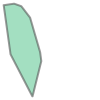

In [76]:
shp_obj

In [77]:
cxb.roads_raw.geometry.intersects(shp_obj).value_counts()

False    258216
True      24370
dtype: int64

In [78]:
cxb.roads_raw = cxb.roads_raw.loc[cxb.roads_raw.geometry.intersects(shp_obj) == True]

having narrowed the DataFrame to the roads we are interested in, we generate the RoadsGDF object

In [79]:
cxb.roads_raw.infra_type.value_counts()

residential       10988
unclassified       5198
living_street      3437
track              1663
service             831
road                737
tertiary            617
secondary           472
primary             192
trunk               125
pier                 97
ferry                 6
trunk_link            5
secondary_link        2
Name: infra_type, dtype: int64

In [80]:
cxb.generateRoadsGDF(verbose = True)

Processing 0 of 24370
Processing 1000 of 24370
Processing 2000 of 24370
Processing 3000 of 24370
Processing 4000 of 24370
Processing 5000 of 24370
Processing 6000 of 24370
Processing 7000 of 24370
Processing 8000 of 24370
Processing 9000 of 24370
Processing 10000 of 24370
Processing 11000 of 24370
Processing 12000 of 24370
Processing 13000 of 24370
Processing 14000 of 24370
Processing 15000 of 24370
Processing 16000 of 24370
Processing 17000 of 24370
Processing 18000 of 24370
Processing 19000 of 24370
Processing 20000 of 24370
Processing 21000 of 24370
Processing 22000 of 24370
Processing 23000 of 24370
Processing 24000 of 24370


C:\Users\wb467985\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


With initialReadIn(), we transform this to a graph object

In [81]:
G = cxb.initialReadIn()

In [82]:
# Optionally, we save this graph object down to file using gn.save()

# gn.save(cxb.network,'CXB_raw','..\intermediate')

### 2 - Cleaning

This function defines the order of GOSTnet functions we will call on the input network object. The verbose flag causes the process to save down intermediate files - helpful for troublehsooting.

In [83]:
# load in if you saved this out
# G = nx.read_gpickle(os.path.join(interm_pth, 'CXB_raw.pickle'))

In [84]:
print('start: %s\n' % time.ctime())
G_clean = gn.clean_network(G, wpath=interm_pth, output_file_name='CXB', UTM = {'init':'epsg:32646'}, WGS = {'init': 'epsg:4326'}, junctdist = 50)
print('\nend: %s' % time.ctime())
print('\n--- processing complete')

start: Fri May  8 10:00:34 2020



C:\Users\wb467985\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\wb467985\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\wb467985\.conda\envs\geo\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:4326 +type=crs != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


23277
44609
20197
38612
Edge reduction: 47408 to 38612 (18 percent)

end: Fri May  8 10:04:05 2020

--- processing complete


In [85]:
# gn.save(G_clean,'CXB_processed',interm_pth)

### 3 - Find Largest Graph

Here, we generate shapefiles of the connected network and those roads which are disconnected. Though not necessary for the analysis, this is a useful process to go through to:
1.) visually appraise the quality of the OSM network
2.) identify large subgraphs that need to be manually connected to the main network
3.) support network improvement activities 

Shapefiles manually edited (as per step 2) can be loaded up in a separate optional process outlined in the next notebok

Import Processed Graph

Add a unique value to each edge

In [93]:
q = 0
for u, v, data in G_clean.edges(data = True):
    data['unique_id'] = q
    q+=1

Identify largest subgraph by making a list of all subgraphs, iterating through them, and setting a variable to the maximum

In [94]:
list_of_graphs = list(G_clean.subgraph(c).copy() for c in nx.strongly_connected_components(G_clean))

In [95]:
max_edges = 0
for q in range(0, len(list_of_graphs)):
        g = list_of_graphs[q]
        if g.number_of_edges() > max_edges:
            max_edges = g.number_of_edges()
            t = q
        else:
            pass

Print the results of this test

In [96]:
print("The largest graphs is the graph in position %s, and has %s edges" % (t, max_edges))

The largest graphs is the graph in position 0, and has 35071 edges


Define largest graph as its own object, save it down

In [97]:
# Export graph

largest_G = list_of_graphs[t]
gn.save(largest_G, 'largest_G', interm_pth)

# Turn into shapefile

edge_gdf_largest_G = gn.edge_gdf_from_graph(largest_G)
edge_gdf_largest_G = edge_gdf_largest_G.drop('geometry', axis = 1)
edge_gdf_largest_G['Wkt'] = edge_gdf_largest_G['Wkt'].apply(lambda x: gn.unbundle_geometry(x))
edge_gdf_largest_G = edge_gdf_largest_G.set_geometry('Wkt')
edge_gdf_largest_G.to_file(os.path.join(interm_pth,'LargestG.shp'))

Create a shapefile of all the edges that aren't in the main graph

In [98]:
edge_gdf = gn.edge_gdf_from_graph(G_clean)

edges_in_largest_G = list(edge_gdf_largest_G.unique_id)

edges_NOT_in_largest_G = edge_gdf.loc[~edge_gdf.unique_id.isin(edges_in_largest_G)]

Save it down

In [99]:
edges_NOT_in_largest_G = edges_NOT_in_largest_G.drop('geometry', axis = 1)
edges_NOT_in_largest_G['Wkt'] = edges_NOT_in_largest_G['Wkt'].apply(lambda x: gn.unbundle_geometry(x))
edges_NOT_in_largest_G = edges_NOT_in_largest_G.set_geometry('Wkt')
edges_NOT_in_largest_G.to_file(os.path.join(interm_pth,'DisconnectedRoads.shp'))

**Optional troubleshooting exports**

Create a shapefile of all edges from the cleaned graph, save it down

In [100]:
# all_edges_G = gn.edge_gdf_from_graph(G_clean)
# all_edges_G = all_edges_G.drop('geometry', axis = 1)
# all_edges_G['Wkt'] = all_edges_G['Wkt'].apply(lambda x: gn.unbundle_geometry(x))
# all_edges_G = all_edges_G.set_geometry('Wkt')
# all_edges_G.to_file(os.path.join(interm_pth,'All_edges_clean.shp'))

Create a shapefile of all edges from the UNcleaned graph, save it down

In [101]:
# all_edges_G = gn.edge_gdf_from_graph(G)
# all_edges_G = all_edges_G.drop('geometry', axis = 1)
# all_edges_G['Wkt'] = all_edges_G['Wkt'].apply(lambda x: gn.unbundle_geometry(x))
# all_edges_G = all_edges_G.set_geometry('Wkt')
# all_edges_G.to_file(os.path.join(interm_pth,'All_edges_Gnormal.shp'))

In [102]:
# gn.save(G_clean,'CXB_clean',interm_pth)

### 4 - Convert to speeds

In [103]:
G_largest = nx.read_gpickle(os.path.join(interm_pth, 'largest_G.pickle'))

Next, we convert the network to time, supplying a speed in km/h for each road type

Define a speed dictionary with a value for every unique road type in the above list

In [104]:
# adjusted for Bangladesh based on Blankespoor and Yoshida (2010)
# Reduced all by 5 to account for CXB traffic congestion and poor road conditions

speeds = {'residential':20,
            'unclassified':15,
            'track':10,
            'tertiary':30,
            'secondary':40,
            'primary':55,
            'trunk':55,
            'service':15,
            'road':15,
            'ferry':15,
            'pier':5,
            'path':5,
            'living_street':20,
            'primary_link':50,
            'tertiary_link':25,
            'secondary_link':35,
            'trunk_link':50}

In [105]:
G_clean_time = gn.convert_network_to_time(G_largest, # G_salted or G_clean
                                      distance_tag = 'length',
                                      graph_type = 'drive',
                                      road_col = 'infra_type',
                                      speed_dict = speeds,
                                      factor = 1000
                                     )

Finally, before saving down, we reset all node IDs to integers to aid the graphtool step

In [106]:
G_clean_time = nx.convert_node_labels_to_integers(G_clean_time) # G_clean vs G_salted

Save down

In [107]:
gn.save(G_clean_time, 'final_current_G', 'final', nodes = True,  edges = True)

### Optional: upgrade speeds on specific segments

In [22]:
G_upgrade_noferry = nx.read_gpickle('final/final_current_G.pickle')
G_upgrade_nosouth = nx.read_gpickle('final/final_current_G.pickle')
G_upgrade_all = nx.read_gpickle('final/final_current_G.pickle')

We manually extract the OSM IDs of the segments we're upgrading (by looking in QGIS) as they are stable and maintained throughout the GOSTNets process

In [23]:
teknaf_ukhia_osm = np.unique(np.array(['525374117','525374117','244861071','244861071','526475489','527094223','529649508','529649508','526475484','526475484','741035023','741035023','528098225','526408634','526408634','527059938','527059938','526933038','525511878','526933038','526933038','527204201','527204201','528098229','655555108','244861071','244861071','244861071','244861071','244861071','244861071','529159711','529159711','525374117','525374117','527016496','527016496','599458428','599458428','527207549','527207549','748990772','748990772','748990772','748990772','525376345','525376345','599458428','599458428','526475484','525374117','529159711','162212277','526475489','526475489','244861071','244861071','527210749','527210749','244861071','244861071','526475489','526475489','32527804','529649516','741036942','741036942','528098229','528098229','526980456','526980456','529649516','529649508','244861071','244861071','748990772','748990772','202518064','202518064','244861071','244861071','526973380','526973380','526475484','526475484','202518064','202518064','244861071','244861071','748990772','748990772','529649508','202518064','527424873','527424873','244861071','244861071','527088835','748990772','528098229','528098229','528098225','528098225','526973380','526973380','599458428','599458428','525374117','525374117','32527804','32527804','527059938','527059938','526973380','526973380','527210749','527210749','526376294','526376294','527088835','527088835','527204201','527204201','527204201','527204201','528098225','529159711','529159711','244861071','244861071','244861071','244861071','527424873','527424873','32527804','162212276','748990772','748990772','526933038','526933038','244861071','244861071','526980456','526980456','525374117','655610101','529649516','529649516','526419382','529649508','529649508','655610101','655610101','162212277','162212277','655555108','655555108','162212277','162212277','526408634','526419382','526408634','526431569','741035023','526431569','741035023','526441357','527088835','526441357','748990772','748990772','748990772','748990772','748990772','748990772','741036942','748990772','741036942','526376294','748990772','748990772','526376294','526376294','526376294','526376294','526376294','599458561','526376294','526376294','599458428','599458561','527210749','599458428','527210749','527210749','527210749','527210749','527210749','527210749','527210749','527201136','527201136','527201136','527094223','527094223','527094223','527094223','526475484','527094223','527094223','527094223','525374117','525374117','525374117','525374117','526475489','527201136','655610101','655610101','655610101','526980456','655610101','655610101','526980456','526980456','526980456','526980456','526980456','527016496','527016496','527016496','527016496','527016496','527016496','527016496','527059938','527016496','526933038','526933038','526933038','527059938','526933038','526933038','526933038','526933038','525511878','525374115','525374115','525374115','525374115','525376345','525376345','525376345','525376345','525374110','525376345','525376345','525374110','526973380','526973380','526973380','526973380','526973380','527424873','526973380','526973380','526973380','527210749','527210749','527204201','527204201','527204201','527204201','527204201','527204201','527204201','527204201','527204201','527207549','554049070','554049070','244861071','554049070','554049070','527207549','527207549','527207549','527207549','527207549','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','244861071','528098229','528098229','528098229','202518064','528098225','528098225','528098225','528098225','655555108','202518064','202518064','529649508','529649508','529649516','529649516','529159711','162212276','202518064','202518064','527204201','527424873','162212277','655508235','655508235','32124439','32124439','32124439','32124439','32124439','32124439','32124439','32124439','32124439','32124439'])).tolist()

In [24]:
upgrade_segs = {'ferry' : ['85651714','85651729','43107027','409823924'], \
                'maheshkhali': ['236712168','423656274','424954822','424955827','424979570','425403567','468297576','468307000','468307004','468312439','468312440'], \
                'charkhari' : ['28887054','162212403','236712167','236712168','236712192','236712195','586014261'],
                'teknaf_ukhia' : teknaf_ukhia_osm}

re-define speeds

In [25]:
# adjusted for Bangladesh based on Blankespoor and Yoshida (2010)
# Reduced all by 5 to account for CXB traffic congestion and poor road conditions

speeds = {'residential':20,
            'unclassified':15,
            'track':10,
            'tertiary':30,
            'secondary':40,
            'primary':55,
            'trunk':55,
            'service':15,
            'road':15,
            'ferry':15,
            'pier':5,
            'path':5,
            'living_street':20,
            'primary_link':50,
            'tertiary_link':25,
            'secondary_link':35,
            'trunk_link':50}

Optional code to check a single edge is upgraded (before / after)

In [26]:
# for u, v, data in G_upgrade_all.edges(data=True):
#     if data['osm_id'] == '244861071':
#         print(data['infra_type'])

In [27]:
# for u, v, data in G_upgrade_nosouth.edges(data=True):
#     if data['osm_id'] == '244861071':
#         print(data['infra_type'])

In [28]:
for u, v, data in G_upgrade_noferry.edges(data=True):
    if data['osm_id'] == '85651714':
        print(data['infra_type'])

ferry
ferry


Change over edges

In [29]:
for u, v, data in G_upgrade_noferry.edges(data = True):
    if data['osm_id'] in upgrade_segs['maheshkhali']:
        data['infra_type'] = 'secondary'
    elif data['osm_id'] in upgrade_segs['charkhari']:
        data['infra_type'] = 'primary'

for u, v, data in G_upgrade_nosouth.edges(data = True):
    if data['osm_id'] in upgrade_segs['ferry']:
        data['infra_type'] = 'secondary'
    elif data['osm_id'] in upgrade_segs['maheshkhali']:
        data['infra_type'] = 'secondary'
    elif data['osm_id'] in upgrade_segs['charkhari']:
        data['infra_type'] = 'primary'

for u, v, data in G_upgrade_all.edges(data = True):
    if data['osm_id'] in upgrade_segs['teknaf_ukhia']:
        data['infra_type'] = 'primary'
    elif data['osm_id'] in upgrade_segs['maheshkhali']:
        data['infra_type'] = 'secondary'
    elif data['osm_id'] in upgrade_segs['charkhari']:
        data['infra_type'] = 'primary'
    elif data['osm_id'] in upgrade_segs['ferry']:
        data['infra_type'] = 'secondary'


ferries are correctly not upgraded as long as they are loaded in as separate graphs

In [30]:
# for u, v, data in G_upgrade_all.edges(data=True):
#     if data['osm_id'] == '244861071':
#         print(data['infra_type'])

In [31]:
# for u, v, data in G_upgrade_nosouth.edges(data=True):
#     if data['osm_id'] == '244861071':
#         print(data['infra_type'])

In [32]:
for u, v, data in G_upgrade_nosouth.edges(data=True):
    if data['osm_id'] == '85651714':
        print(data['infra_type'])

secondary
secondary


In [33]:
# remove factor!! not needed because speeds were already coputed

G_upgrade_noferry_time = gn.convert_network_to_time(G_upgrade_noferry,
                                      distance_tag = 'length',
                                      graph_type = 'drive',
                                      road_col = 'infra_type',
                                      speed_dict = speeds
                                     )

G_upgrade_nosouth_time = gn.convert_network_to_time(G_upgrade_nosouth,
                                      distance_tag = 'length',
                                      graph_type = 'drive',
                                      road_col = 'infra_type',
                                      speed_dict = speeds
                                     )

G_upgrade_all_time = gn.convert_network_to_time(G_upgrade_all,
                                      distance_tag = 'length',
                                      graph_type = 'drive',
                                      road_col = 'infra_type',
                                      speed_dict = speeds
                                     )

In [34]:
gn.save(G_upgrade_noferry_time, 'final_upgrade_noferry_G', 'final', nodes = False,  edges = False)
gn.save(G_upgrade_nosouth_time, 'final_upgrade_nosouth_G', 'final', nodes = False,  edges = True)
gn.save(G_upgrade_all_time, 'final_upgrade_all_G', 'final', nodes = False,  edges = True)